In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Add, Conv2DTranspose, LeakyReLU, add, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, ELU
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as k
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.applications import DenseNet121

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:
# download the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

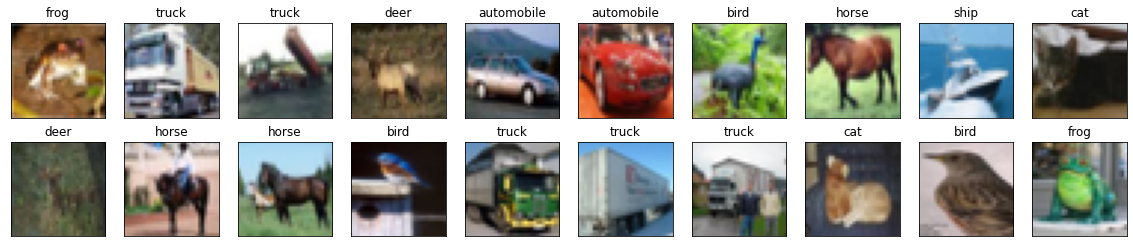

In [ ]:
# show some sample images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = plt.subplot(2, 10, idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(x_train[idx])
  plt.title(class_names[int(y_train[idx])])

In [ ]:
# change data type as float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# normalize image data 
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
# one hot encoding
# Now we one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# shape o images
print('Shape of taining images: ', x_train.shape)
print('Shape of taining labels: ', y_train.shape)
print()
print('Shape of testing images: ', x_test.shape)
print('Shape of testing labels: ', y_test.shape)

Shape of taining images:  (50000, 32, 32, 3)
Shape of taining labels:  (50000, 10)

Shape of testing images:  (10000, 32, 32, 3)
Shape of testing labels:  (10000, 10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = load_model('./drive/My Drive/Defense_Method/models/Mnet.h5')

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

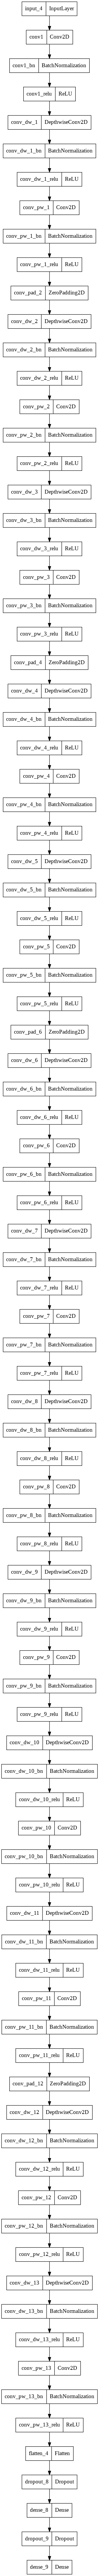

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
predictions = model.predict(x_test)
#np.argmax(predictions[0])

In [ ]:
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print('Test Accuracy: ', round(orig_accuracy, 4))
print('Test Los: ', round(orig_loss, 4))

32/32 [==============================] - 1s 20ms/step - loss: 0.6852 - accuracy: 0.8230

Test Accuracy:  0.823
Test Los:  0.6852


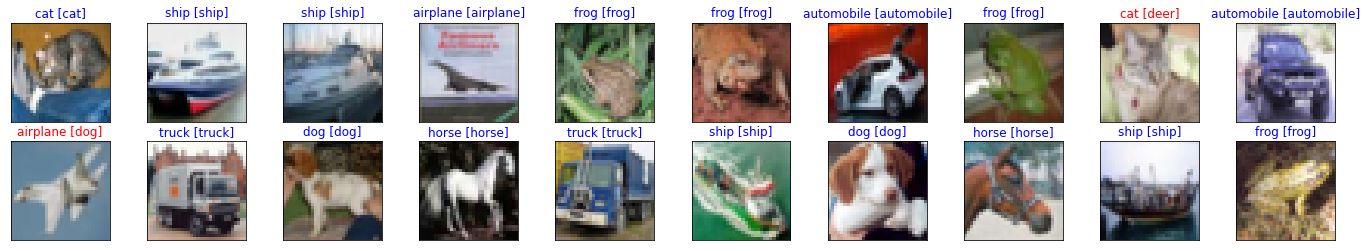

In [ ]:
#show some test images
fig = plt.figure(figsize=(24, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(x_test[idx])
  
  if class_names[int(np.argmax(predictions[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(predictions[idx]))] + "]", color = color)

# Fast Gradient Sign Method (FGSM)

In [ ]:
# accuracy and loss of model on test data
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(orig_accuracy, 4))
print("Model Loss on test images: ", round(orig_loss, 4))

32/32 [==============================] - 0s 11ms/step - loss: 0.6852 - accuracy: 0.8230

Model Accuracy on test images:  0.823
Model Loss on test images:  0.6852


In [ ]:
epsilons = 0.02

In [ ]:
import pickle
out = open('./drive/My Drive/Defense_Method/adv_examples/fgsm.pickle', 'rb')
adv_fgsm = pickle.load(out)

In [ ]:
adv_pred = model.predict(adv_fgsm)

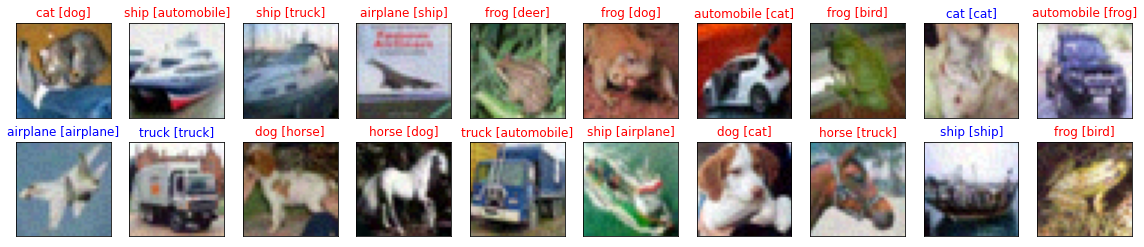

In [ ]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_fgsm[idx], 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_fgsm, y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 12ms/step - loss: 7.6996 - accuracy: 0.1820

Model Accuracy on test images:  0.182
Model Loss on test images:  7.6996


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/Defense_Method/models/runet_fgsm.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
deniose_fgsm = d_model.predict(adv_fgsm)
deniose_fgsm = np.clip(deniose_fgsm, 0, 1)

In [ ]:
# predict some restored images
predictions = model.predict(deniose_fgsm)

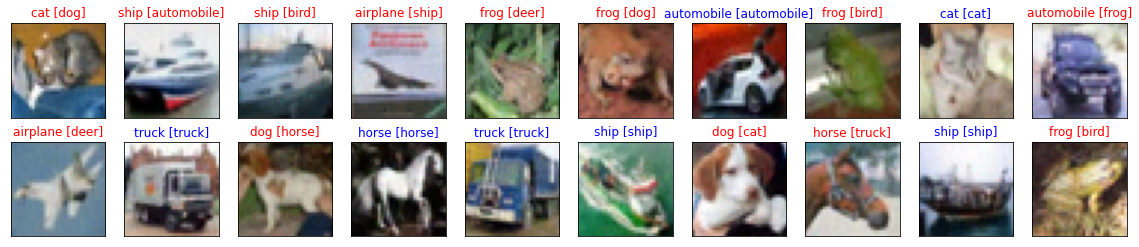

In [ ]:
# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  #plt.imshow(denise_images[idx].reshape(28, 28), cmap = 'gray')
  
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(deniose_fgsm[idx])
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(deniose_fgsm, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 10ms/step - loss: 2.6670 - accuracy: 0.5110

Model Accuracy on restored images:  0.511
Model Loss on test images:  2.667


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.6245


# Basic Iterative Method (BIM)

In [ ]:
# accuracy and loss of model on test data
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(orig_accuracy, 4))
print("Model Loss on test images: ", round(orig_loss, 4))

32/32 [==============================] - 0s 12ms/step - loss: 0.6852 - accuracy: 0.8230

Model Accuracy on test images:  0.823
Model Loss on test images:  0.6852


In [ ]:
pred = model.predict(x_test[:1000])

label = []
for i in range(len(pred)):
  y_pred = np.argmax(pred[i])
  l = label.append(y_pred) 


labels = np.asarray(label)

images = tf.cast(x_test[:1000], dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

#images = ep.astensor(images)
#labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

# create attack
attack = foolbox.attacks.L2BasicIterativeAttack()

# create adversarial example
raw_adv, adv_bim, success = attack(fmodel, images, criterion = c, epsilons = 0.2)

# adversarial purtubation
bim_p = adv_bim - x_test[:1000]

In [ ]:
eps = 0.3

In [ ]:
adv_pred = model.predict(adv_bim)

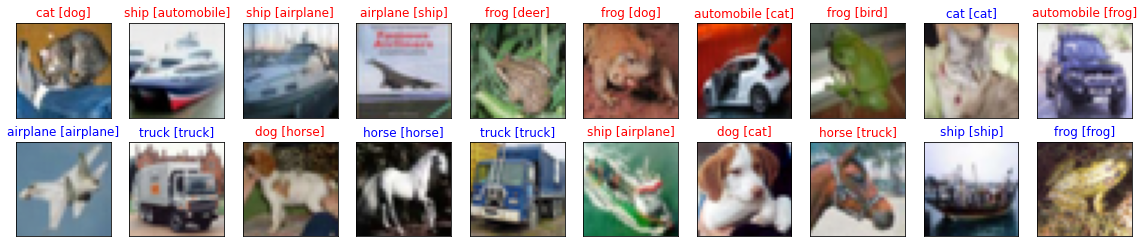

In [ ]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_bim[idx].numpy(), 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_bim, y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 5.8206 - accuracy: 0.3360

Model Accuracy on test images:  0.336
Model Loss on test images:  5.8206


In [ ]:
# load denoising model to remove BIM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/Defense_Method/models/runet_mnet.h5')

In [ ]:
# Restore adversarial images created due to BIM attack 
deniose_bim = d_model.predict(adv_bim)
deniose_bim = np.clip(deniose_bim, 0, 1)

In [ ]:
# predict some restored images
predictions = model.predict(deniose_bim)

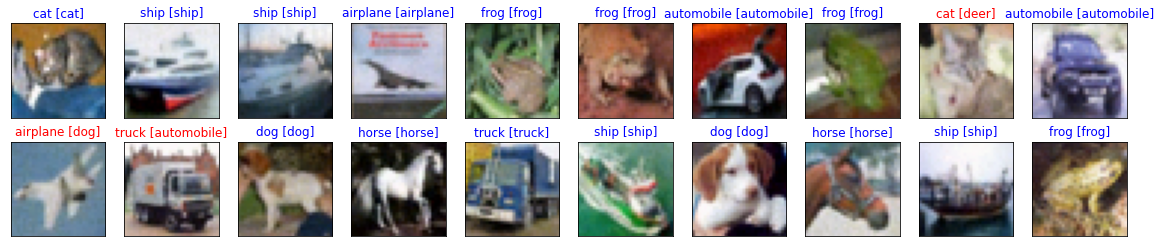

In [ ]:
# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(deniose_bim[idx])
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(deniose_bim, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 2.8251 - accuracy: 0.7970

Model Accuracy on restored images:  0.797
Model Loss on test images:  2.8251


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9733


In [ ]:
import pickle
out = open('./drive/My Drive/Defense_Method/adv_examples/bim.pickle', 'wb')
pickle.dump(adv_bim, out)

# Projected Gradient Descent (PGD)

In [ ]:
# accuracy and loss of model on test data
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(orig_accuracy, 4))
print("Model Loss on test images: ", round(orig_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.8230

Model Accuracy on test images:  0.823
Model Loss on test images:  0.6852


In [ ]:
pred = model.predict(x_test[:1000])

label = []
for i in range(len(pred)):
  y_pred = np.argmax(pred[i])
  l = label.append(y_pred) 


labels = np.asarray(label)

images = tf.cast(x_test[:1000], dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

#images = ep.astensor(images)
#labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

# create attack
attack = foolbox.attacks.PGD()

# create adversarial example
raw_adv, adv_pgd, success = attack(fmodel, images, criterion = c, epsilons = 0.005)

# adversarial purtubation
pgd_p = adv_pgd - x_test[:1000]

In [ ]:
adv_pred = model.predict(adv_pgd.numpy())

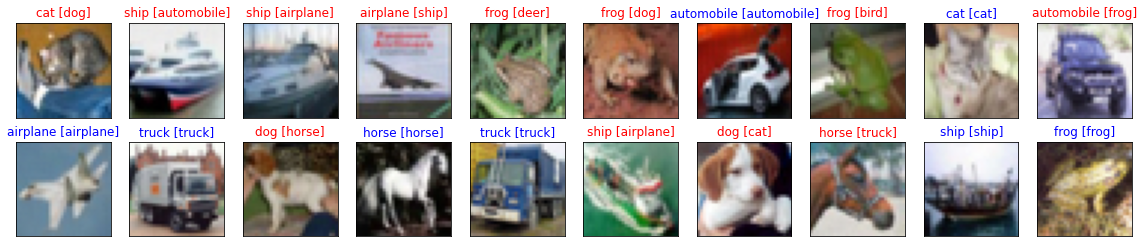

In [ ]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_pgd[idx].numpy(), 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_pgd.numpy(), y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 8ms/step - loss: 3.9980 - accuracy: 0.4200

Model Accuracy on test images:  0.42
Model Loss on test images:  3.998


In [ ]:
# load denoising model to remove PGD putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/Defense_Method/models/runet_mnet.h5')

In [ ]:
# Restore adversarial images created due to PGD attack 
deniose_pgd = d_model.predict(adv_pgd.numpy())
deniose_pgd = np.clip(deniose_pgd, 0, 1)

In [ ]:
# predict some restored images
predictions = model.predict(deniose_pgd)

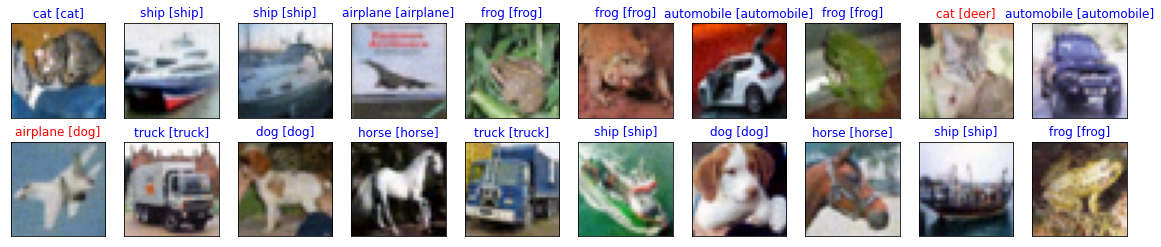

In [ ]:
# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(deniose_pgd[idx])
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(deniose_pgd, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 8ms/step - loss: 2.8510 - accuracy: 0.7990

Model Accuracy on restored images:  0.799
Model Loss on test images:  2.851


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9708


# Deep Fool Attack

In [ ]:
# accuracy and loss of model on test data
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(orig_accuracy, 4))
print("Model Loss on test images: ", round(orig_loss, 4))

32/32 [==============================] - 0s 8ms/step - loss: 0.6852 - accuracy: 0.8230

Model Accuracy on test images:  0.823
Model Loss on test images:  0.6852


In [ ]:
pred = model.predict(x_test[:1000])

label = []
for i in range(len(pred)):
  y_pred = np.argmax(pred[i])
  l = label.append(y_pred) 


labels = np.asarray(label)

images = tf.cast(x_test[:1000], dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

#images = ep.astensor(images)
#labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

# create attack
attack = foolbox.attacks.L2DeepFoolAttack()

# create adversarial example
raw_adv, adv_dfa, success = attack(fmodel, images, criterion = c, epsilons = 0.7)

# adversarial purtubation
dfa_p = adv_dfa - x_test[:1000]

In [ ]:
adv_pred = model.predict(adv_dfa.numpy())

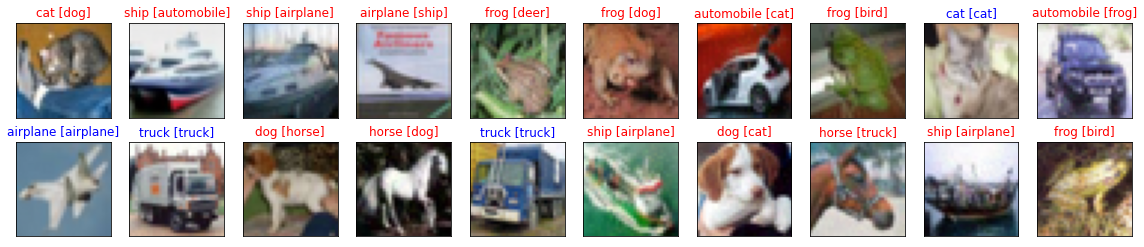

In [ ]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_dfa[idx].numpy(), 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_dfa.numpy(), y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 8ms/step - loss: 4.3344 - accuracy: 0.2310

Model Accuracy on test images:  0.231
Model Loss on test images:  4.3344


In [ ]:
# load denoising model to remove DFA putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/Defense_Method/models/runet_mnet.h5')

In [ ]:
# Restore adversarial images created due to DFA attack 
deniose_dfa = d_model.predict(adv_dfa.numpy())

In [ ]:
# predict some restored images
predictions = model.predict(deniose_dfa)

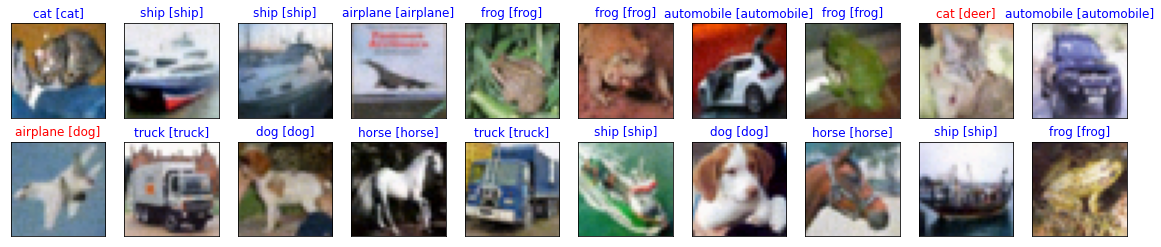

In [ ]:
# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(deniose_dfa[idx])
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(deniose_dfa, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 8ms/step - loss: 2.6770 - accuracy: 0.8100

Model Accuracy on restored images:  0.81
Model Loss on test images:  2.677


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9842


# Carlini and Wanger Attack

In [ ]:
# accuracy and loss of model on test data
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(orig_accuracy, 4))
print("Model Loss on test images: ", round(orig_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.8230

Model Accuracy on test images:  0.823
Model Loss on test images:  0.6852


In [ ]:
import pickle
cwa_file = open('./drive/My Drive/Defense_Method/adv_examples/cwa.pickle', 'rb')
adv_cwa = pickle.load(cwa_file) 

In [ ]:
import pickle
cwa = open('./drive/My Drive/PhD_Thesis/adversarial_noise/cifar10/cifar10_cw_5_noise.pickle', 'rb')
cwa_noise = pickle.load(cwa)

In [ ]:
adv_cwa = x_test[:1000] + 4*cwa_noise

In [ ]:
# accuracy and loss of model on test data
adv_loss, adv_accuracy = model.evaluate(adv_cwa[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 1.5094 - accuracy: 0.6500

Model Accuracy on test images:  0.65
Model Loss on test images:  1.5094


In [ ]:
adv_pred = model.predict(adv_cwa)

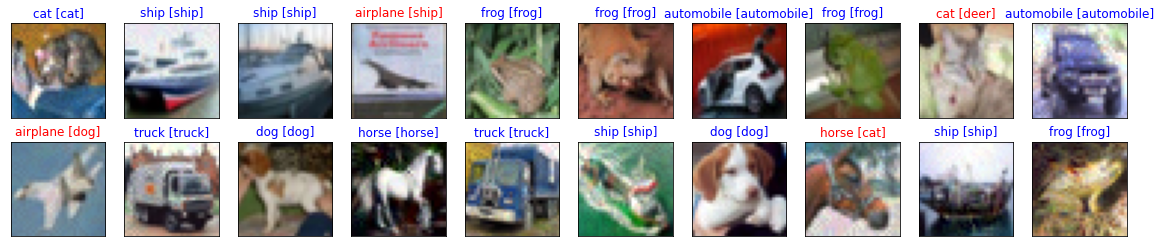

In [ ]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_cwa[idx], 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/Defense_Method/models/runet_mnet.h5')

In [ ]:
# Restore adversarial images created due to CWA attack 
deniose_cwa = d_model.predict(adv_cwa)

In [ ]:
# predict some restored images
predictions = model.predict(deniose_cwa)

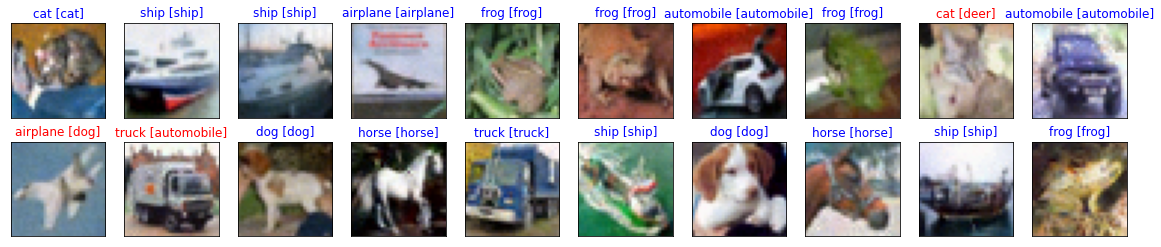

In [ ]:
# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  #plt.imshow(denise_images[idx].reshape(28, 28), cmap = 'gray')
  
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(np.clip(deniose_cwa[idx], 0, 1))
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(deniose_cwa, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 2.8150 - accuracy: 0.7880

Model Accuracy on restored images:  0.788
Model Loss on test images:  2.815


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9575


In [ ]:
import pickle
out = open('./drive/My Drive/Defense_Method/restored_images/rest_cwa.pickle', 'wb')
pickle.dump(deniose_cwa, out)

# Spatial Attack

In [ ]:
# accuracy and loss of model on test data
orig_loss, orig_accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print()
print("Model Accuracy on test images: ", round(orig_accuracy, 4))
print("Model Loss on test images: ", round(orig_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.8230

Model Accuracy on test images:  0.823
Model Loss on test images:  0.6852


In [ ]:
#!pip install foolbox
import foolbox

In [ ]:
pred = model.predict(x_test[:1000])

label = []
for i in range(len(pred)):
  y_pred = np.argmax(pred[i])
  l = label.append(y_pred) 


labels = np.asarray(label)

images = tf.cast(x_test[:1000], dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

#images = ep.astensor(images)
#labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

# create attack
attack = foolbox.attacks.SpatialAttack()

# create adversarial example
raw_adv, adv_spa, success = attack(fmodel, images, criterion = c)

# adversarial purtubation
spa_p = adv_spa - x_test[:1000]

In [ ]:
adv_pred = model.predict(adv_spa.numpy())

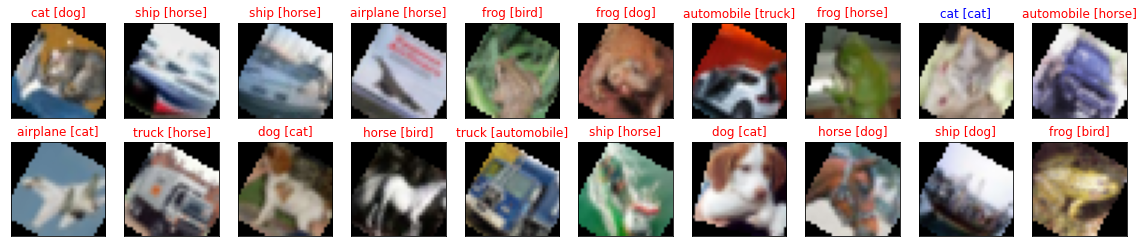

In [ ]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_spa[idx].numpy(), 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_spa.numpy(), y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 10ms/step - loss: 3.5980 - accuracy: 0.0540

Model Accuracy on test images:  0.054
Model Loss on test images:  3.598


In [ ]:
# load denoising model to remove SPA putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/Defense_Method/models/runet_spa.h5')

In [ ]:
# Restore adversarial images created due to SPA attack 
deniose_spa = d_model.predict(adv_spa.numpy())

In [ ]:
# predict some restored images
predictions = model.predict(deniose_spa)

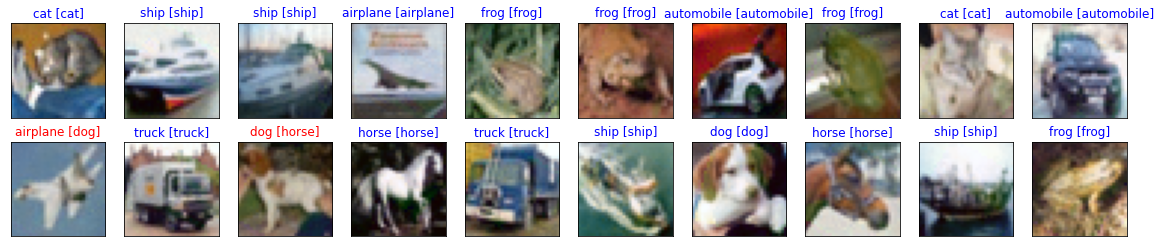

In [ ]:
# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(np.clip(deniose_spa[idx], 0, 1))
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(deniose_spa, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 9ms/step - loss: 0.7715 - accuracy: 0.8040

Model Accuracy on restored images:  0.804
Model Loss on test images:  0.7715


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9769


In [ ]:
import pickle
out = open('./drive/My Drive/Defense_Method/restored_images/spa.pickle', 'wb')
pickle.dump(deniose_spa, out)

# Some examples of Restored examples

In [ ]:
adv_examples = np.concatenate([adv_dfa[8:12], adv_bim[12:14], adv_pgd[14:16], adv_dfa[18:20], adv_spa[16:18]])
adv_examples.shape

(12, 32, 32, 3)

In [ ]:
adv_pert = np.concatenate([fgsm_p[8:12], bim_p[12:14], pgd_p[14:16], dfa_p[18:20], spa_p[16:18]])

adv_pert = 10 * adv_pert
adv_pert.shape

(12, 32, 32, 3)

In [ ]:
restored_examples = np.concatenate([deniose_fgsm[8:12], deniose_bim[12:14], deniose_pgd[14:16], deniose_dfa[18:20], deniose_spa[16:18]])
restored_examples.shape 

(12, 32, 32, 3)

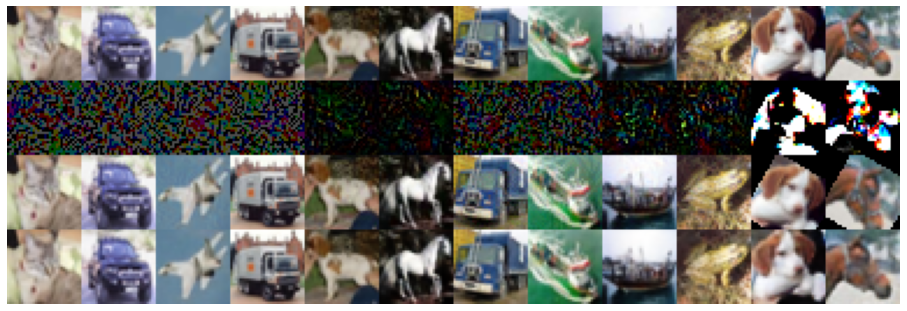

In [ ]:
imgs = np.concatenate([x_test[8:16],x_test[18:20],x_test[16:18], adv_pert, adv_examples, restored_examples[:12]])
imgs = imgs.reshape((4, 12, 32, 32, 3))

imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize = (16, 6))
plt.axis('off')
#plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(np.clip(imgs, 0, 1))